In [107]:
"""
Get data from https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2024&min_date=01%2F01%2F2023&max_date=12%2F31%2F2024
Filter by employer is "uchicago" or "university of chicago" (appears to do some fuzzy matching)
Took contrib from 15-16, 17-18, 19-20, 21-22, and 23-24 cycle

"""
import numpy as np
import pandas as pd
from plotnine import *  #for ggplot

In [108]:
#CONSTANTS

COL_NAMES = ["committee_id", "committee_name", "report_year", "transaction_id", "contributor_name",
             "contributor_first_name", "contributor_middle_name",
             "contributor_last_name", "contributor_city", "contributor_zip", 
             "contributor_employer", "contributor_occupation", 
             "contribution_receipt_date", "contribution_receipt_amount", 
             "receipt_type_desc", "election_type", "two_year_transaction_period"]

In [109]:
def import_and_clean_donations(file):
    """
    Data cleaning for an individual contributions csv file from FEC

    Args: file(.csv): CSV file of donations from 
                      www.fec.gov/data/receipts/individual-contributions 

    Returns: clean pandas DataFrame
    """
    
    df = pd.read_csv(file, low_memory = False)
    
    #truncate table, filter down to uchicago and professors
    df_trunc = df[COL_NAMES]

    employer_filter = "ILLINOIS|LOYOLA| IL |ILINOIS|STATE|ILLNOIS|IL,|IL-|\
                  ILNOIS|LLLINOIS|ILLIONIS|ILLINIOS|LAB SCHOO|LABORATORY SCHOO"  
    df1 = df_trunc[~df_trunc.contributor_employer.str.contains(employer_filter)]
    
    occupation_filter = "PROF|TEACHER|LECTURER|EDUCATOR"
    occupation_filter2 = 'PROFESSIONAL'

    df1 = df1[df1.contributor_occupation.str.match(occupation_filter, na=False)]
    df1 = df1[~df1.contributor_occupation.str.match(occupation_filter2, na=False)]

    #convert to datetime

    df1['date_clean'] = pd.to_datetime(df_trunc['contribution_receipt_date'])
    df1['year'] = df1['date_clean'].dt.year
    df1['month'] = df1['date_clean'].dt.month

    #combine BFP and BVF
    mask = df1["committee_name"].isin(['BIDEN FOR PRESIDENT', 'BIDEN VICTORY FUND'])
    df1["committee_name"] = np.where(mask, 'BIDEN FOR PRESIDENT/BIDEN VICTORY FUND', df1["committee_name"] )

    #add in PAC political leanings
        # spreadsheet is here: 
        # https://docs.google.com/spreadsheets/d/1hvFXe1kRBVdUSjRFkGjoLqkUXC3N49Bh4_N1_hVqfKg/edit#gid=899646531
    df1["committee_name"] = df1["committee_name"].str.strip()

    pac_lean = pd.read_csv("pac_lean.csv")
    pac_lean["committee_name"] = pac_lean["committee_name"].str.strip()
    clean_pac_fec = df1.join(pac_lean.set_index('committee_name'), on = 'committee_name', how='left')

    # add real dollars using cpi for each contrib
        # spreadsheet is here: 
        # https://docs.google.com/spreadsheets/d/1kkerChNNxOL3pRGEsFynXL1T1mVyNRRCCPlNF20WmOw/edit#gid=990329749
    cpi_df = pd.read_csv("cpi_15_23.csv")
    filter = (cpi_df['month'] == 10) & (cpi_df['year'] == 2023) 
    cpi_current = float(cpi_df[filter]['cpi'])
    cpi_df['conversion'] = cpi_current / cpi_df['cpi']
    cpi_df.drop('cpi', axis=1, inplace=True)

    clean_pac_fec = pd.merge(clean_pac_fec, cpi_df, on = ['month', 'year'], how='left')
    clean_pac_fec['real_donation'] = clean_pac_fec['contribution_receipt_amount'] * clean_pac_fec['conversion']
    clean_pac_fec.drop('conversion', axis=1, inplace=True)

    return clean_pac_fec

In [110]:
def create_lookup_table(df):
    """
    create person, committee, year lookup table

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()

    Return: transformed pandas DataFrame

    example use cases
    # Biggest R donors
    df[df.simple_lean == 'R'].groupby('contributor_name')['contribution_sum'].sum().nlargest(10)
    # person lookup for all donations
    df[df.contributor_name.str.contains(NAME)]
    """

    #fill 'na's 
    df['contributor_employer'] = df['contributor_employer'].astype("string").fillna("NA")
    df['contributor_occupation'] = df['contributor_occupation'].astype("string").fillna("NA")

    # row for each 
    person_comm_year = df.groupby(['contributor_name', 'committee_name', 
                                      'two_year_transaction_period', 'simple_lean']).agg({
    'contributor_employer': lambda x: ', '.join(x.unique()),
    'contributor_occupation': lambda x: ', '.join(x.unique()),
    'contribution_receipt_amount': ['sum', 'median', 'count']
    }).reset_index()

    #get rid of hierarchical column index
    person_comm_year.columns = [''.join(col).strip() for col in person_comm_year.columns.values]
    person_comm_year.columns = ['contributor_name', 'committee_name', 
                                'two_year_transaction_period', 'simple_lean',
                                'contributor_employer', 'contributor_occupation',
                                  'contribution_sum', 'contribution_median', 'contribution_count']
    
    return person_comm_year

In [130]:
def donations_by_year_lean(df, period):
    """
    creates df of sum donations by year and lean for chart 

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()

    Return: transformed pandas DataFrame
    """
    if period == "together":
        df = df.groupby('simple_lean')\
                        ['real_donation'].sum().reset_index()
    elif period == "by_year": 
        df = df.groupby(['two_year_transaction_period','simple_lean'])\
                        ['real_donation'].sum().reset_index()
        df.columns = ['two_year_transaction_period', 'simple_lean', 'contribution_sum']

    return df

In [112]:
def donations_by_month(df):
    """
    creates of sum donations by month for chart 

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()

    Return: transformed pandas DataFrame
    """

    df_by_month = df.groupby(['year','month'])['real_donation'].sum().reset_index()
    df_by_month['date'] = pd.to_datetime(df_by_month.year.astype(str) + "-" + 
                                         df_by_month.month.astype(str) + "-" + '1')

    return df_by_month

In [113]:
def compare_2020_2024(df):
    """
    creates df to compare 2020 to date to 2024 

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()

    Return: transformed pandas DataFrame
    """

    col_trunc = ["date_clean", "month", "year", "real_donation", 
             "two_year_transaction_period"]
    date_filter = df["two_year_transaction_period"].isin([2020,2024])
    
    df = df[col_trunc]
    df = df[date_filter]

    # create a common date to compare cumsum across elections
    cond_list = [
        df['year'] == 2018,
        df['year'] == 2019,
        df['year'] == 2020,
        df['year'] == 2022,
        df['year'] == 2023
    ]

    choice_list = [
        1998,
        1999,
        2000,
        1998,
        1999
    ]

    df['chart_year'] = np.select(cond_list,choice_list)
    
    df['chart_date'] = pd.to_datetime(df['chart_year'].astype(str) +
                                        "-" + df['month'].astype(str) +
                                        "-" + (df['date_clean'].dt.day).astype(str))
    
    df['two_year_transaction_period'] = df['two_year_transaction_period'].astype(int)

    # create date array of all days
    date_array = pd.DataFrame(pd.date_range(start='2018-10-12', end='2023-10-31'), columns = ['date_clean'])
    df = date_array.join(df.set_index('date_clean'), on = 'date_clean') 

    mask = df['date_clean'] < '2022-09-22'
    df["two_year_transaction_period"] = np.where(mask, 2020, 2024)
    df['real_donation'] = df['real_donation'].fillna(0)

    # create cumsum for each election
    df = df.groupby('date_clean').agg({
                    'two_year_transaction_period': lambda x: max(x),
                    'two_year_transaction_period': lambda x: max(x),
                    'real_donation': 'sum'  
                    }).reset_index()
    

    df = df.sort_values(by=['date_clean']).reset_index(drop=True)

    df['cumsum'] = df.groupby('two_year_transaction_period')['real_donation'].cumsum()

    #cut off 2020 to current date of 2024
    max_date_2024 = df[df['two_year_transaction_period'] == 2024]['date_clean'].max()
    max_date_2020 = pd.Timestamp("2019-"+ str(max_date_2024.month) + '-'+ str(max_date_2024.day))
    filter1 = df['date_clean'] <= max_date_2020
    filter2 = df['two_year_transaction_period'] == 2020
    filter3 = df['two_year_transaction_period'] == 2024

    df = df[(filter1 & filter2) | filter3]

    return df

In [114]:
def cume_by_cycle(df):
    """
    creates df to compare 2020 to date to 2024 

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()

    Return: transformed pandas DataFrame
    """

    col_trunc = ['contribution_receipt_date', "date_clean", "month", "year", "real_donation", 
             "two_year_transaction_period"]
    
    df = df[col_trunc]

    df['two_year_transaction_period'] = df['two_year_transaction_period'].astype(int)

    years = list(df['two_year_transaction_period'].unique())

    full_df = pd.DataFrame()

    for year in years:
        new_df = df[df['two_year_transaction_period'] == year]

        min_date = new_df['contribution_receipt_date'].min().split()[0]
        max_date = new_df['contribution_receipt_date'].max().split()[0]
        date_array = pd.DataFrame(pd.date_range(start = min_date, end = max_date), columns = ['date_clean'])
        new_df = date_array.join(new_df.set_index('date_clean'), on = 'date_clean').reset_index()

        new_df["two_year_transaction_period"] = new_df['two_year_transaction_period'].fillna(year) 
        new_df['real_donation'] = new_df['real_donation'].fillna(0)

        # create cumsum for each election
        new_df = new_df.groupby('date_clean').agg({
                    'two_year_transaction_period': lambda x: max(x),
                    'real_donation': 'sum'  
                    }).reset_index()
    

        new_df = new_df.sort_values(by=['date_clean']).reset_index(drop=True)
        new_df['cumsum'] = new_df.groupby('two_year_transaction_period')['real_donation'].cumsum()

        if full_df.size == 0:
            full_df = new_df
        else:
            full_df = pd.concat([full_df,new_df])
    """
    #cut off 2020 to current date of 2024
    max_date_2024 = df[df['two_year_transaction_period'] == 2024]['date_clean'].max()
    max_date_2020 = pd.Timestamp("2019-"+ str(max_date_2024.month) + '-'+ str(max_date_2024.day))
    filter1 = df['date_clean'] <= max_date_2020
    filter2 = df['two_year_transaction_period'] == 2020
    filter3 = df['two_year_transaction_period'] == 2024

    df = df[(filter1 & filter2) | filter3]
    """

    return full_df.sort_values(by = ['two_year_transaction_period','date_clean'])

In [115]:
def top_pacs(df, cycle, lean, n = 5):
    """
    creates df to of the top pacs for a given year and 

    args:
        df (pandas DataFrame): tables cleaned table from import_and_clean_donations()
        cycle (int): year of selected election (2016, 2018, 2020, 2022, or 2024)
        lean (string): "R" or "D" or "all"
        n (int): number of pacs you want displayed per lean

    Return: transformed pandas DataFrame
    """

    if lean == 'all':
        filter = df.two_year_transaction_period == cycle
    else:
        filter = (df.two_year_transaction_period == cycle) & (df.simple_lean == lean)
        
    pac_df = df[filter].groupby(["committee_name", "two_year_transaction_period", "simple_lean"])\
                ['real_dollars'].sum().nlargest(n).reset_index()
    
    return pac_df

create tables for charts

In [131]:
#clean_df = import_and_clean_donations('fec_uc_16_24.csv')

#cume_by_cycle_df = cume_by_cycle(clean_df)

#election_lean_df = donations_by_year_lean(clean_df, 'together')

#election_2020_2024 = compare_2020_2024(clean_df)

#by_month_df = donations_by_month(clean_df)


chart mockups

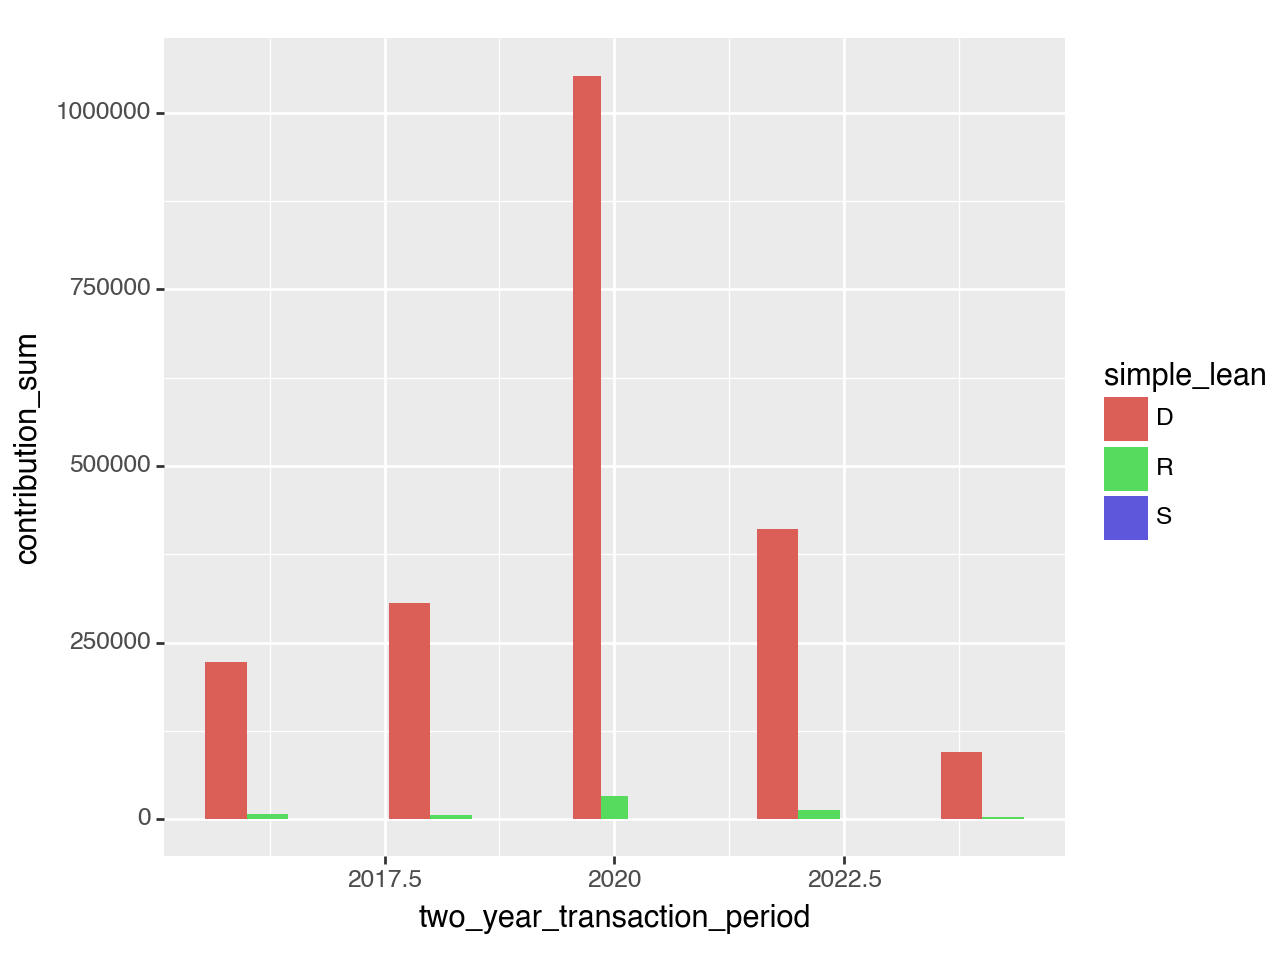

<Figure Size: (640 x 480)>

In [ ]:
#contributions by election by lean
(ggplot(election_lean_df)         # defining what data to use
 + aes(x = 'two_year_transaction_period', y = ('contribution_sum'), fill = 'simple_lean')   # defining what variable to use
 + geom_col(position = 'dodge') # defining the type of plot to use
)

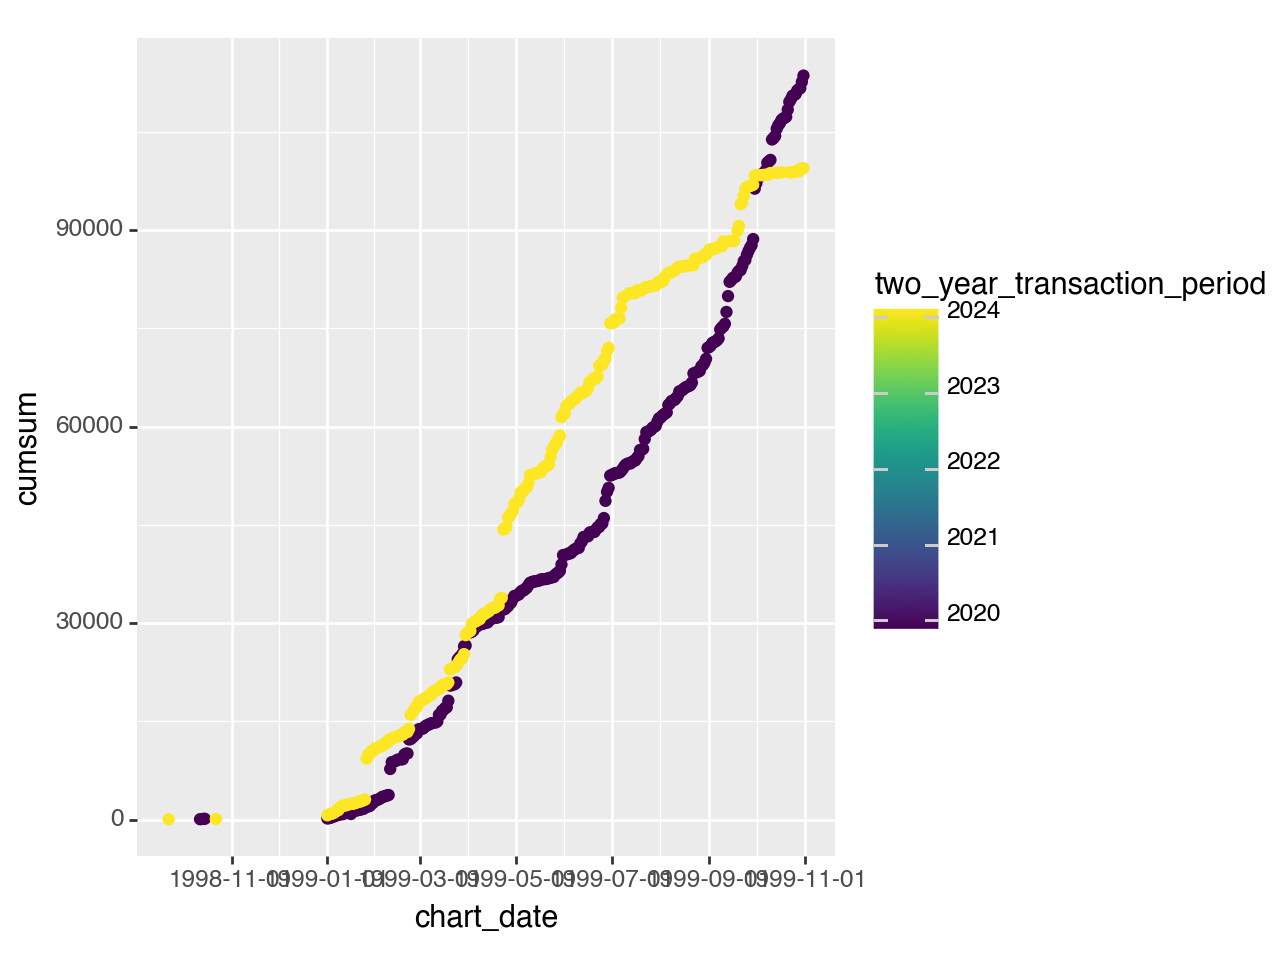

<Figure Size: (640 x 480)>

In [ ]:
# compare 2020 to date vs 2024
(ggplot(election_2020_2024) 
 + aes(x = 'chart_date', y = 'cumsum', color = 'two_year_transaction_period') 
 + geom_point()
)

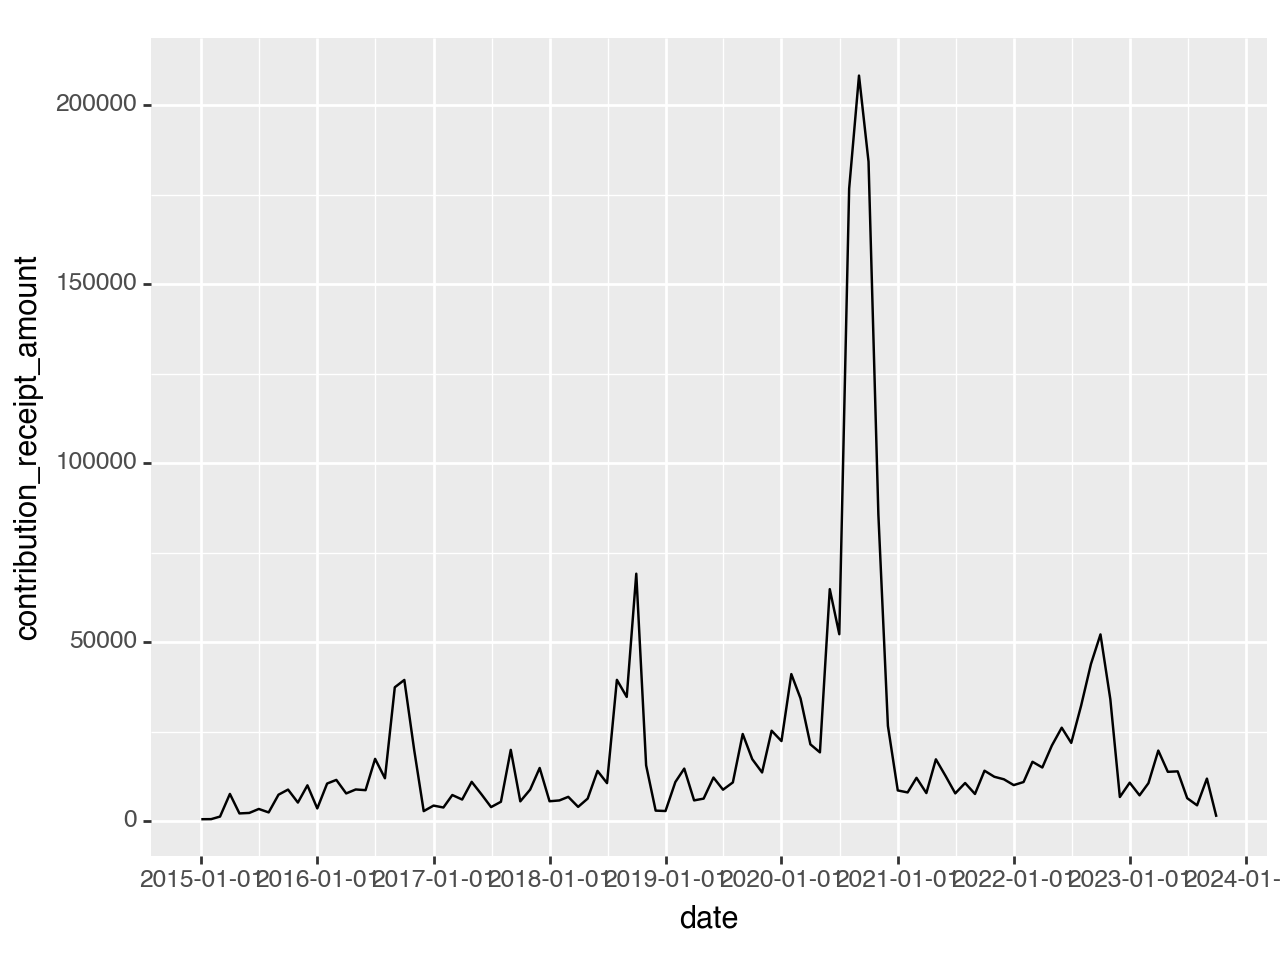

<Figure Size: (640 x 480)>

In [ ]:
#donations over time
(ggplot(by_month_df) 
 + aes(x = 'date', y = 'contribution_receipt_amount')  
 + geom_line() 
)